In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler

In [2]:
## Test Data
fake_test_data = pd.read_csv('./Data/test.csv')

In [3]:
fake_test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
## create dataset
fake_news_df = pd.read_csv('./Data/train.csv')

In [5]:
fake_news_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [6]:
## Merge data for new column

fake_news_df["merged"] = fake_news_df["title"]+" "+fake_news_df["author"]

fake_news_df.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,Iranian woman jailed for fictional unpublished...


In [7]:
#  check null values
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
merged    2515
dtype: int64

In [8]:
# drop null values
fake_news_df=fake_news_df.dropna()

In [9]:
# Now count the Unique values using np.unique to find the elements of an array as parameter
count = np.unique(fake_news_df['label'], return_counts=True)
print(count)

(array([0, 1], dtype=int64), array([10361,  7924], dtype=int64))


<AxesSubplot:xlabel='label', ylabel='count'>

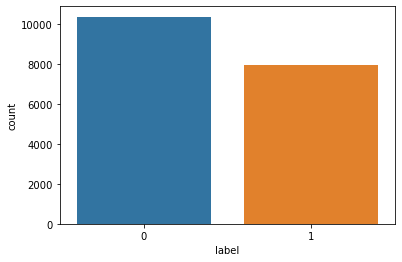

In [10]:
import seaborn as sns
sns.countplot(x='label', data = fake_news_df)

In [11]:
# Dependent Features
Y = fake_news_df['label']

# Independent Features
X = fake_news_df.drop('label', axis=1)

In [12]:
# change the dataset into numerical representation
# make the copy of Dependent Featues and reset the index because we drop the nan values due to this 
# the index is disturb
messages = X.copy()
# messages.reset_index(inplace=True)

In [13]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [14]:
messages.reset_index(inplace=True)

In [15]:
# Data processing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vida_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [17]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['merged'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [18]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [19]:
voc_size = 5000
onehot_repre = [one_hot(words, voc_size) for words in corpus]
onehot_repre[0]

[353, 652, 761, 2786, 592, 3084, 1039, 1274, 1842, 4395, 3788, 885]

In [20]:
# Word embedding
sent_length = 20
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[   0    0    0    0    0    0    0    0  353  652  761 2786  592 3084
 1039 1274 1842 4395 3788  885]


In [21]:
## CREATING A MODEL

In [22]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
x_final = np.array(embedded_docs)
y_final = np.array(Y)

In [24]:
x_final.shape, y_final.shape

((18285, 20), (18285,))

In [25]:
## SPLIT THE DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

In [26]:
# MODEL TRAINING
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)


Epoch 1/20
258/258 [==============================] - 8s 21ms/step - loss: 0.1966 - accuracy: 0.9118 - val_loss: 0.0338 - val_accuracy: 0.9885
Epoch 2/20
258/258 [==============================] - 5s 19ms/step - loss: 0.0191 - accuracy: 0.9947 - val_loss: 0.0239 - val_accuracy: 0.9923
Epoch 3/20
258/258 [==============================] - 5s 20ms/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.0298 - val_accuracy: 0.9913
Epoch 4/20
258/258 [==============================] - 5s 19ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0375 - val_accuracy: 0.9874
Epoch 5/20
258/258 [==============================] - 5s 19ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0275 - val_accuracy: 0.9923
Epoch 6/20
258/258 [==============================] - 5s 18ms/step - loss: 1.8979e-04 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9929
Epoch 7/20
258/258 [==============================] - 5s 19ms/step - loss: 9.8932e-05 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy

In [27]:
# PERFORMANCE METRICS AND ACCURACY
classes_x = (model.predict(X_test) > 0.5).astype("int32")

58/58 [==============================] - 1s 5ms/step


In [28]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[1030,    6],
       [   7,  786]], dtype=int64)

In [29]:
#Accuracy Score
from sklearn.metrics import accuracy_score
score_0 = accuracy_score(y_test,classes_x)
print(score_0)

0.9928922908693275


In [65]:
# Model 1 is the Logistic Regression Model
model_1 = LogisticRegression(max_iter=900)

# Fitting the model
model_1.fit(X_train,y_train)

# Making predictions using the testing data 
pred_1 = model_1.predict(X_test)

# Calculating the accuracy score.
score_1 = accuracy_score(y_test,pred_1)
print(score_1)

0.7096774193548387


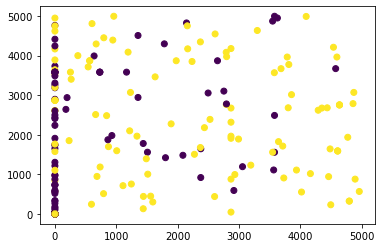

In [52]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

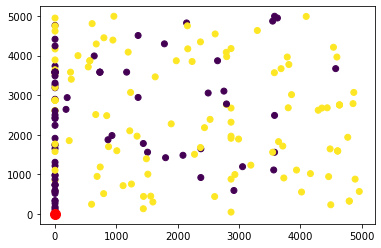

In [53]:
import numpy as np
new_data = np.array([[-2, 6]])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.scatter(new_data[0, 0], new_data[0, 1], c="r", marker="o", s=100)
plt.show()

In [71]:
# Making a prediction
X_new = X_test[0]
prediction = model_1.predict(X_new)
print(prediction)
if (prediction[0]==0):
    print('The news is Real')
else:
    print('The news is Fake')


ValueError: Expected 2D array, got 1D array instead:
array=[   0    0    0    0    0    0    0    0    0    0    0 4824 3915  323
 3664 3599 1529 4175  895 2447].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [58]:
# Model 2 is Random Over Sampler
# Resample the training data with the RandomOverSampler
model_2 = RandomForestClassifier()

# Fitting the model
model_2.fit(X_train,y_train)

# Making predictions using the testing data 
pred_2 = model_2.predict(X_test)

# Calculating the accuracy score.
score_2 = accuracy_score(y_test,pred_2)
print(score_2)

0.8939311098961181


In [49]:
results = pd.DataFrame([["Logistic Regression",score_1],
                       ["Random Forest",score_2]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.709677
1,Random Forest,0.896118
